In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Add path ../../..
Connected DB


In [2]:
import os
import numpy as np

In [3]:
import matplotlib.image as mpimg

In [4]:
from IPython.display import HTML

# NAMESPACE

In [5]:
class NAMESPACE:
    # Base values
    TABLE_NAME = 'DW_LIMIT_FCT'
    SEL_SAMPLE = 'SAMPLE1_SUB1'
    
    # Important to look
    QUERY = f"""SELECT X.* FROM DW_ANALYTICS.{TABLE_NAME} X JOIN CINS_TMP_ALY_CUST_{SEL_SAMPLE} SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE"""
    
    # Derived values
    data_fp = f'./data/{TABLE_NAME}'
    data_sample_nm = os.path.join(data_fp, SEL_SAMPLE)
    IMG_FP = f'./img/{TABLE_NAME}'
    img = f'./img/{TABLE_NAME}/{SEL_SAMPLE}'
    
    def show():
        atts = dir(NAMESPACE)
        for a in atts:
            if not a.startswith('__'):
                print(a)
    
    @classmethod
    def init(cls):
        if not os.path.exists(NAMESPACE.data_fp):
            os.makedirs(NAMESPACE.data_fp)
        if not os.path.exists(NAMESPACE.img):
            os.makedirs(NAMESPACE.img)

In [6]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DW_LIMIT_FCT X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB1 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [7]:
NAMESPACE.init()

In [8]:
NAMESPACE.show()

IMG_FP
QUERY
SEL_SAMPLE
TABLE_NAME
data_fp
data_sample_nm
img
init
show


In [9]:
stat_opt = [
            'count',
            'mean',
            'median',
            'min',
            'max',
            'std',
]
ordered_stat_opt = [[i, i + '_pct_chg'] for i in stat_opt]
ordered_stat_opt = [j for i in ordered_stat_opt for j in i]

# Functions

In [10]:
def aly_datetime(df, date_col, cde_col, resample='1Y', outlier_date='1930-01-01', timedelta='365 days',lvl=3):
    display(HTML(f'<h{lvl}>{date_col}</h{lvl}>'))
    if cde_col is None:
        tmp_df = df[date_col].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col).resample(resample).nunique()
    else:
        tmp_df = df[[date_col, cde_col]].copy()
        tmp_df[date_col] = pd.to_datetime(tmp_df[date_col], errors='coerce')
        tmp_df[date_col] = df[date_col].astype('datetime64[D]')
        tmp = tmp_df[tmp_df[date_col] > outlier_date]
        plot_df = tmp.set_index(date_col)[cde_col].resample(resample).nunique()
    
    fig, axs = plt.subplots(1,2, figsize=(15, 5))
    plot_df.plot(kind='bar', rot=70, ax=axs[0])
    up2now = ((datetime(2023,11,1) - tmp[date_col]) / pd.Timedelta(timedelta)).apply(float)
    sns.histplot(up2now, kde=True, ax=axs[1])
    plt.show()

In [11]:
def default_func(x):
    return x

In [12]:
def remove_mode_value(x):
    return x[~x.isin(x.mode().values)]

In [13]:
def logx(x):
    return np.log(x)

In [14]:
def plot_multi_hist_aly(df,cols=[],funcs=[default_func, remove_mode_value, logx], lvl=3):
    def df_stat_after_transformed(df_trans):
        def pct_change(series):
            first_e = series.iloc[0]
            pct_chg = (series - first_e) / first_e * 100
            pct_chg.iloc[0] = 100.
            return pct_chg
        stat_infos = []
        for data_trans_series in df_trans:
            # Get stats info
            stat_info = []
            for s in stat_opt:
                if s == 'count':
                    stat_info.append(data_trans_series.count())
                elif s == 'mean':
                    stat_info.append(data_trans_series.mean())
                elif s == 'median':
                    stat_info.append(data_trans_series.median())
                elif s == 'min':
                    stat_info.append(data_trans_series.min())
                elif s == 'max':
                    stat_info.append(data_trans_series.max())
                elif s == 'std':
                    stat_info.append(data_trans_series.std())
            stat_infos.append(stat_info)
        col_stat = stat_opt
        index_stat = [f.__name__ for f in funcs]
        stat_df = pd.DataFrame(data=stat_infos, columns=col_stat, index=index_stat)
        for c in stat_df.columns:
            stat_df[f'{c}_pct_chg'] = pct_change(stat_df[c])
        stat_df = stat_df[ordered_stat_opt]
        result_df = stat_df.T
        return result_df
    
    nrows, ncols = len(cols), len(funcs)
    for i, c in enumerate(cols):
        display(HTML(f'<h{lvl}>{c}</h{lvl}>'))
        if c in df.columns:
            data_trans = []
            for f in funcs:
                pre_data_tran = data_trans[-1] if len(data_trans) > 0 else df[c]
                trans_data = f(pre_data_tran)
                data_trans.append(trans_data)
            # plot section 
            fig, axs = plt.subplots(1,ncols, figsize=(4* ncols, 4 ))
            for j, d in enumerate(data_trans):
                sel_ax = axs[j]
                sel_ax.set_title(f'{cols[i]}\n{funcs[j].__name__}')
                d.replace([np.inf, -np.inf], np.nan).plot(kind='hist',bins=100,ax=sel_ax)
            pd.options.display.float_format = '{:.3f}'.format
            display(df_stat_after_transformed(data_trans))
            plt.tight_layout()
            plt.savefig(os.path.join(NAMESPACE.img, f'{c}.jpg'), dpi=500)
            plt.show()
            print('\n\n\n')

In [15]:
def aly_cat_col(df,cat_cols,k=10, lvl=3):
    for cat_col in cat_cols: 
        display(HTML(f'<h{lvl}>{cat_col}</h{lvl}>'))
        fig,axs=plt.subplots(1,2,figsize=(10,5))
        display(df[cat_col].value_counts())
        df[cat_col].value_counts()[:k].plot(kind='bar', rot=80,ax=axs[0])
        df[cat_col].value_counts()[:k].plot(kind='pie', autopct='%.2f%%',ax=axs[1])
        plt.savefig(os.path.join(NAMESPACE.img, f'{cat_col}.jpg'), dpi=500)
        plt.show()

In [16]:
def download_or_reload(saved_file):
    if not os.path.exists(saved_file):
        query = NAMESPACE.QUERY
        cur.execute(query)
        result = cur.fetchall()
        column_names = [c[0] for c in cur.description]
        df = pd.DataFrame(result, columns=column_names)
        df.to_pickle(saved_file)
    df = pd.read_pickle(saved_file)
    print(f'Len {len(df)}')
    return df

In [17]:
def gen_info_stats(df):
    def info_stats(c):
        dtype = df[c].dtype
        n = len(df)
        null_pct = (n - df[c].count()) / n
        nunique = df[c].nunique()
        nunique_pct = nunique / n
        unique_values = df[c].unique()[:3]
        return c, null_pct, dtype, nunique, nunique_pct, unique_values

    data_stats = []
    for c in df.columns:
        data_stats.append(info_stats(c))
    data_stats = pd.DataFrame(data=data_stats,columns=['Column', 'Null Pct', 'Dtype', 'Nunique', 'Nunique Pct', 'Sample Unique Value'])
    return data_stats

# Sample1-Sub*

In [18]:
NAMESPACE.QUERY

'SELECT X.* FROM DW_ANALYTICS.DW_LIMIT_FCT X JOIN CINS_TMP_ALY_CUST_SAMPLE1_SUB1 SAM ON X.CUSTOMER_CDE = SAM.CUSTOMER_CDE'

In [19]:
df = download_or_reload(NAMESPACE.data_sample_nm)

Len 89482


In [20]:
df

,LIMIT_ID,COMPANY_KEY,COMPANY_CDE,DAY_KEY,CUSTOMER_KEY,CUSTOMER_CDE,SUB_INDUSTRY_CDE,SUB_SECTOR_CDE,SUB_SEGMENT_CDE,CUS_TARGET_CDE,...,LIMIT_BAND,ONLINE_LIMIT,LIMIT_PRODUCT_CDE,LIMIT_TYPE_INIT,AMT_CLEAN_RISK,AMT_CLEAN_RISK_USED,AMT_FX_USED_LCL,AMT_SOLD_LCL,AMT_FX_LCL,LOCAL_REF
0,4559335.0001000.01,1,VNI,2022306,30123286,4559335,4243,1700,-1,1001,...,None,None,1000,0001000,None,None,None,None,None,None
1,4559335.0001010.01,1,VNI,2022306,30123286,4559335,4243,1700,-1,1001,...,None,None,1010,0001010,None,None,None,None,None,None
2,4559335.0001500.01,1,VNI,2022306,30123286,4559335,4243,1700,-1,1001,...,None,None,1500,0001500,None,None,None,None,None,None
3,12444505.0001500.01,1,VNI,2022273,38052312,12444505,4231,1700,-1,2001,...,None,None,1500,0001500,None,None,None,None,None,None
4,761947.0005000.01,1,VNI,2022273,11164416,761947,4243,1700,-1,2004,...,None,0,5000,0005000,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89477,1923688.0025000.01,1,VNI,2021365,27464250,1923688,7311,1700,-1,2001,...,None,0,5000,0025000,None,None,None,None,None,VN0011228
89478,14986766.0001500.01,1,VNI,2021365,35876082,14986766,4231,1700,-1,2001,...,None,None,1500,0001500,None,None,None,None,None,None
89479,5942522.0009700.01,1,VNI,2021365,32431659,5942522,4231,1700,-1,2001,...,None,None,9700,0009700,None,None,None,None,None,None
89480,5942522.0020000.01,1,VNI,2021365,32431659,5942522,4231,1700,-1,2001,...,None,0,20000,0020000,None,None,None,None,None,VN0011382


In [21]:
data_stats = gen_info_stats(df)
data_stats

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
0,LIMIT_ID,0.000000,object,3646,0.040746,"[4559335.0001000.01, 4559335.0001010.01, 45593..."
1,COMPANY_KEY,0.000000,int64,1,0.000011,[1]
2,COMPANY_CDE,0.000000,object,1,0.000011,[VNI]
3,DAY_KEY,0.000000,int64,25,0.000279,"[2022306, 2022273, 2022305]"
4,CUSTOMER_KEY,0.000000,int64,1871,0.020909,"[30123286, 38052312, 11164416]"
5,CUSTOMER_CDE,0.000000,object,1599,0.017870,"[4559335, 12444505, 761947]"
6,SUB_INDUSTRY_CDE,0.000000,object,82,0.000916,"[4243, 4231, 7311]"
7,SUB_SECTOR_CDE,0.000000,object,11,0.000123,"[1700, 1309, 1209]"
8,SUB_SEGMENT_CDE,0.000000,object,4,0.000045,"[-1, 190 , 177 ]"
9,CUS_TARGET_CDE,0.000000,object,10,0.000112,"[1001, 2001, 2004]"


In [22]:
df.describe()

,COMPANY_KEY,DAY_KEY,CUSTOMER_KEY,RATE,AMT_INTERNAL,AMT_ADVISED,AMT_MAX_SECURED,AMT_MAX_UNSECURED,AMT_MAX_TOT,AMT_OTHER_SECURED,AMT_SECURED,AMT_ONLINE_LIMIT,AMT_OS_TOT,AMT_AVAIL
count,89482.0,8.948200e+04,8.948200e+04,89482.000000,8.948200e+04,8.948200e+04,8.948200e+04,8.948200e+04,4.740600e+04,3.649100e+04,8.948200e+04,8.948200e+04,8.948200e+04,8.948200e+04
mean,1.0,2.022181e+06,2.878748e+07,20.770792,3.548080e+08,2.871492e+08,1.262214e+08,2.312863e+06,4.873244e+08,4.159548e+08,4.505345e+07,2.177676e+08,-9.134428e+07,1.298193e+08
std,0.0,1.898257e+02,1.088153e+07,682.929147,1.659314e+09,1.121971e+09,8.713281e+08,5.521051e+07,2.204287e+09,2.166225e+09,4.689296e+08,1.540483e+09,6.474478e+08,1.396105e+09
min,1.0,2.021365e+06,1.966330e+05,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.913333e+10,-7.150000e+09
25%,1.0,2.022120e+06,2.144966e+07,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.0,2.022213e+06,3.002385e+07,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.0,2.022303e+06,3.721175e+07,1.000000,2.000000e+08,1.500000e+08,0.000000e+00,0.000000e+00,2.200000e+08,2.200000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.0,2.022365e+06,4.697545e+07,24817.000000,3.000000e+10,2.500000e+10,2.500000e+10,2.000000e+09,3.000000e+10,3.000000e+10,1.913333e+10,3.000000e+10,5.237430e+07,3.000000e+10


## EDA

Selected some col data to EDA, possible these col are good to go, (can be customized):
- Category data:
    - Unique Pct <= x (too many leading data can be identified easily)
    - Nunique > 1 (=1 doesn't mean anything)
- Numerical data: good to select all

In [23]:
valid_info = None 
try: 
    valid_info = data_stats[((data_stats['Nunique Pct'] <= 0.3) & (data_stats['Nunique']>1) & (data_stats['Dtype']==object)) | ((data_stats['Dtype']!=object) & (data_stats['Nunique']>1))]
    valid_info = valid_info[~valid_info['Column'].isin([
        'CARD_KEY', 'CUSTOMER_CDE', 'CUSTOMER_KEY', 'SUB_BRANCH_KEY', 'SUB_BRANCH_CDE', 'COMPANY_KEY',
        'DAO_KEY', 'DAO_CDE', 'CREATE_DT', 'UPDATE_DT', 'NHAP_USERID', 'DUYET_USERID', 'NHANTHAMDINH_USERID',
        'RECOMMENDER_NO', 'RECOMMENDER_NAME', 'CARDHOLDER_NO', 'CRD_BASIC_CDE', 'NEW_CARDCODE', 'ID_NO', 'INDIVIDUAL_ACCT_ID',
        'TXN_ID', 'DAY_KEY', 'USER_KEY', 'USER_CDE', 'CORP_ID', 'ACCT_ID_FROM', 'SUB_BRANCH_KEY_FROM', 'SUB_BRANCH_CDE_FROM',
        'SUB_BRANCH_CDE_TO', 'SUB_BRANCH_KEY_TO', 'ACCT_ID_FROM', 'ACCT_NICKNAME_FROM', 'CONSUMER_CDE', 
        'PARENT_ID', 'USER_ID', 'USER_NAME', 'USER_DO', 'PRODUCT_ID', 'FROM_ACCT_ID', 'TO_ACCT_FULLNAME', 
        'PAYMENT_REF_NO', 'CARD_NO', 'COLLATERAL_ID', 'LOCAL_REF', 'DESCRIPTION', 'ADDRESS', 'INPUTTER', 'AUTHOR_ID', 'REC_UPDATE_DT','REC_CREATE_DT'
    ])]
    
    display(valid_info.head(50))
except Exception as e:
    pass

,Column,Null Pct,Dtype,Nunique,Nunique Pct,Sample Unique Value
0,LIMIT_ID,0.000000,object,3646,0.040746,"[4559335.0001000.01, 4559335.0001010.01, 45593..."
6,SUB_INDUSTRY_CDE,0.000000,object,82,0.000916,"[4243, 4231, 7311]"
7,SUB_SECTOR_CDE,0.000000,object,11,0.000123,"[1700, 1309, 1209]"
8,SUB_SEGMENT_CDE,0.000000,object,4,0.000045,"[-1, 190 , 177 ]"
9,CUS_TARGET_CDE,0.000000,object,10,0.000112,"[1001, 2001, 2004]"
10,CURRENCY_CDE,0.000000,object,2,0.000022,"[VND, USD]"
11,REVIEW_FREQUENCY,0.574428,object,803,0.008974,"[None, 20110425M0125, 20190625M1225]"
12,PRODUCT_ALLOWED,0.783252,object,14,0.000156,"[None, 2000, 5000]"
13,FIXED_VARIABLE,0.592197,object,2,0.000022,"[None, FIXED, VARIABLE]"
14,COLLATERAL_CODE,0.798339,object,16,0.000179,"[None, 2, 100]"


4559335.0001000.01     25
295148.0020000.01      25
6817702.0010000.01     25
6817702.0012000.01     25
12625011.0001500.01    25
                       ..
2173374.0025000.01      1
5434743.0009700.01      1
10935202.0005000.01     1
3782715.0009700.01      1
5094826.0009700.01      1
Name: LIMIT_ID, Length: 3646, dtype: int64

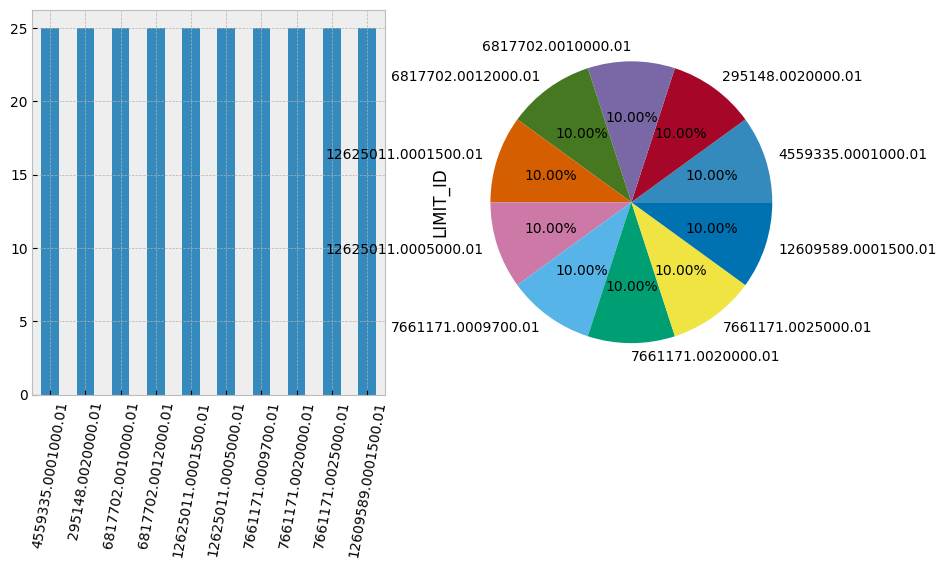

4231    20033
7311    12584
4711     8912
4243     8391
1011     7164
        ...  
201        28
3030       25
451        25
1512       25
3252       25
Name: SUB_INDUSTRY_CDE, Length: 82, dtype: int64

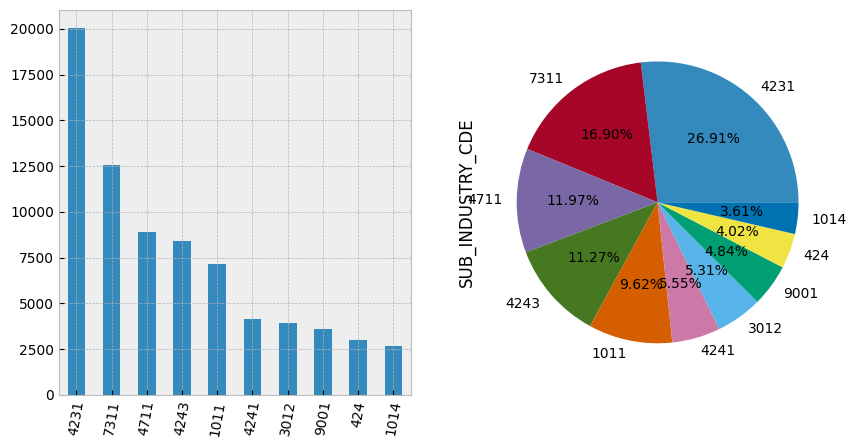

1700    84454
1309     3428
1209      725
1401      300
1601      250
2000       75
1600       75
1602       50
1300       50
8006       50
1100       25
Name: SUB_SECTOR_CDE, dtype: int64

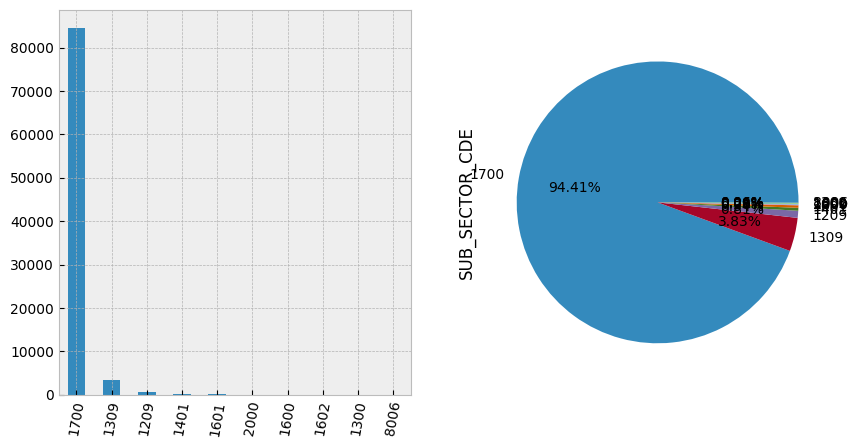

-1            86841
190            2041
178             325
177             275
Name: SUB_SEGMENT_CDE, dtype: int64

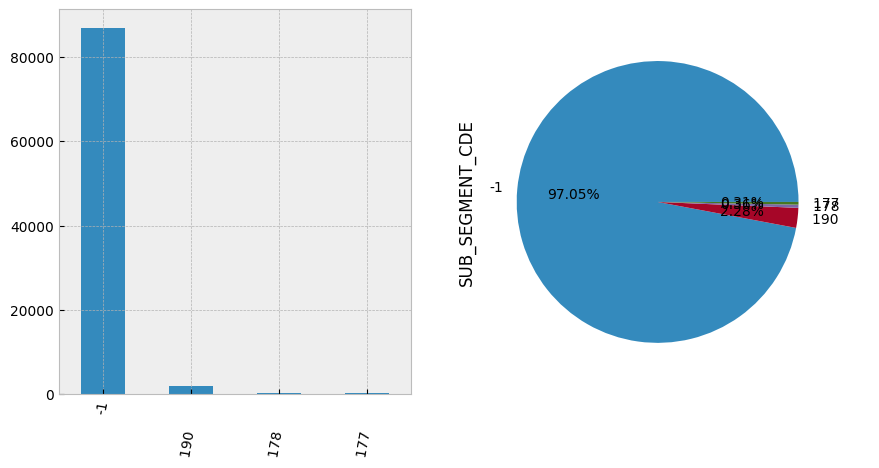

2001    53078
2004    22378
1001    11610
2002     1310
2003      375
1003      328
1002      275
3001       75
9999       28
1004       25
Name: CUS_TARGET_CDE, dtype: int64

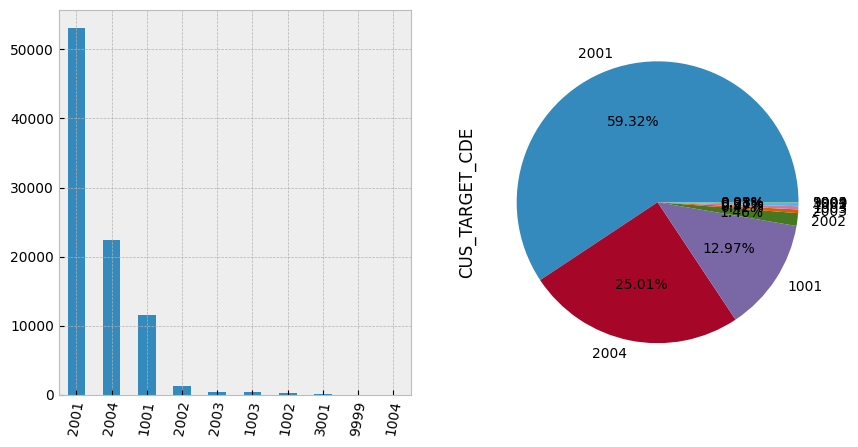

VND    89407
USD       75
Name: CURRENCY_CDE, dtype: int64

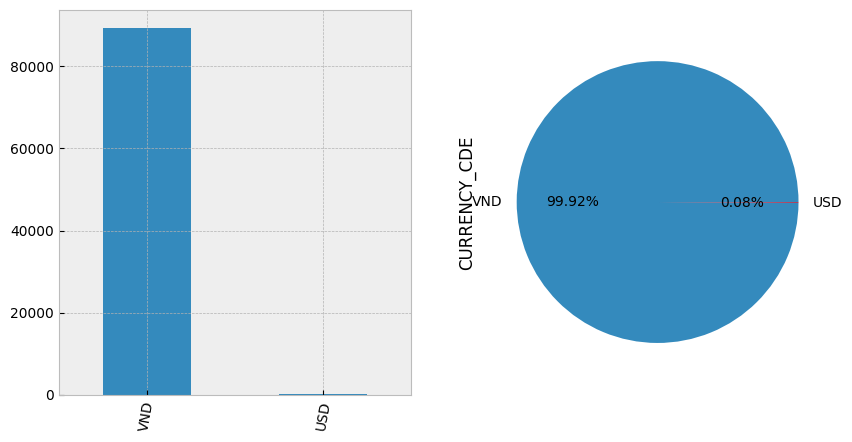

20100918M0101    1825
20100904M0101     575
20100807M0101     375
20100821M0101     250
20180310M1210     100
                 ... 
20231223M1223       2
20230630M0101       2
20220106M0306       2
20231208M0107       1
20251207M0107       1
Name: REVIEW_FREQUENCY, Length: 803, dtype: int64

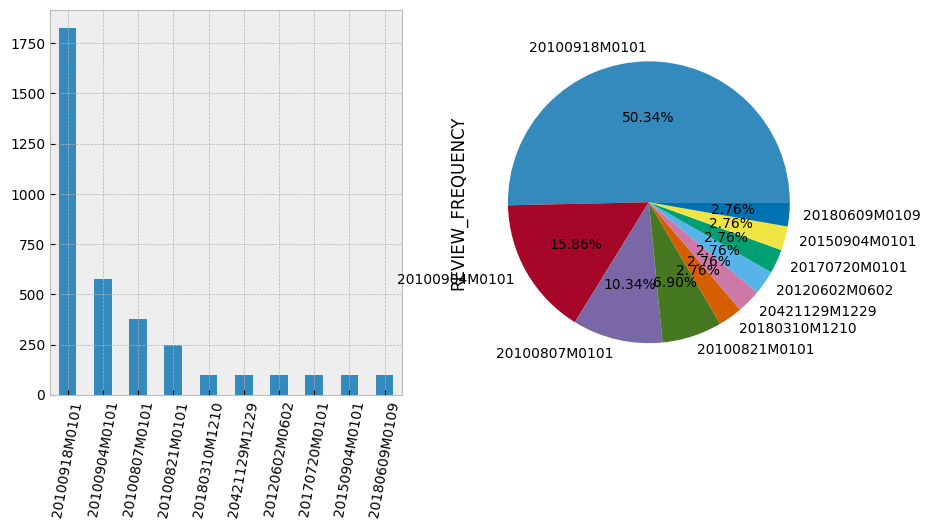

5000         13508
2000          5170
4600           125
3001           125
6000            92
2000|3000       76
3000            75
4601            50
6001            49
4608            25
4603            25
4000            25
4001            25
4603|4604       25
Name: PRODUCT_ALLOWED, dtype: int64

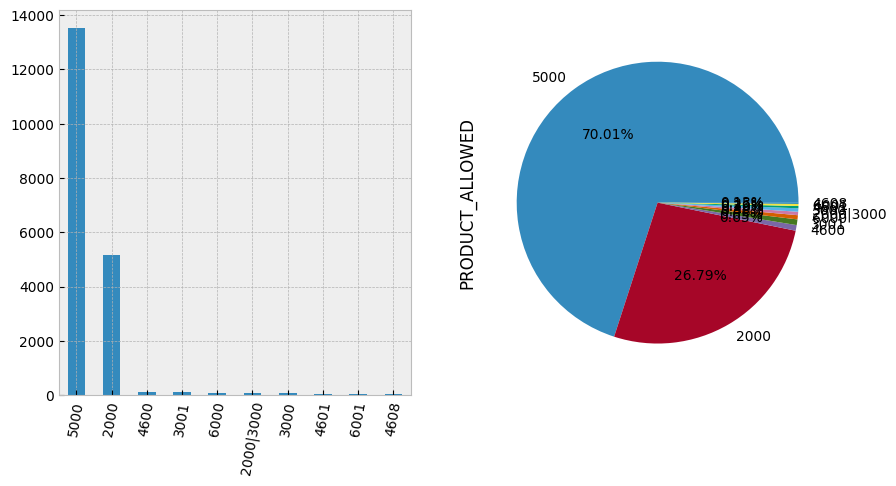

FIXED       22054
VARIABLE    14437
Name: FIXED_VARIABLE, dtype: int64

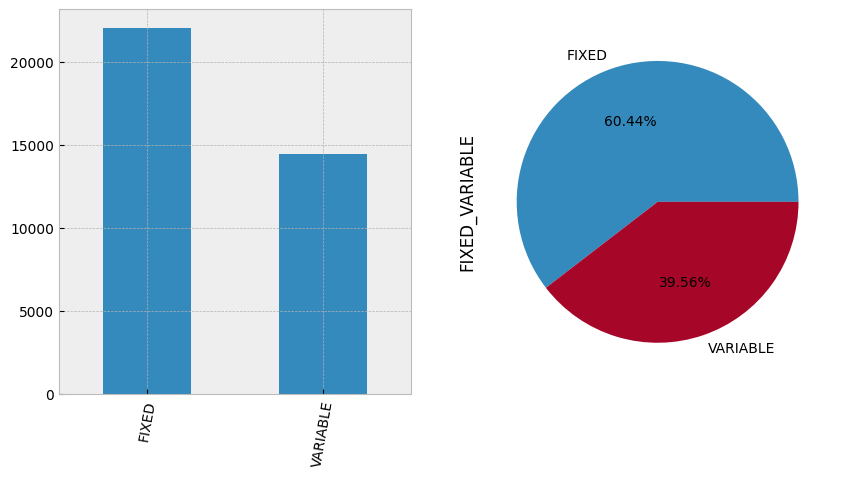

300        11146
10          2075
2           1800
100         1198
600          651
8            475
11           300
300|600      125
800           50
900|300       50
900           50
600|300       25
12            25
10|8          25
15            25
300|11        25
Name: COLLATERAL_CODE, dtype: int64

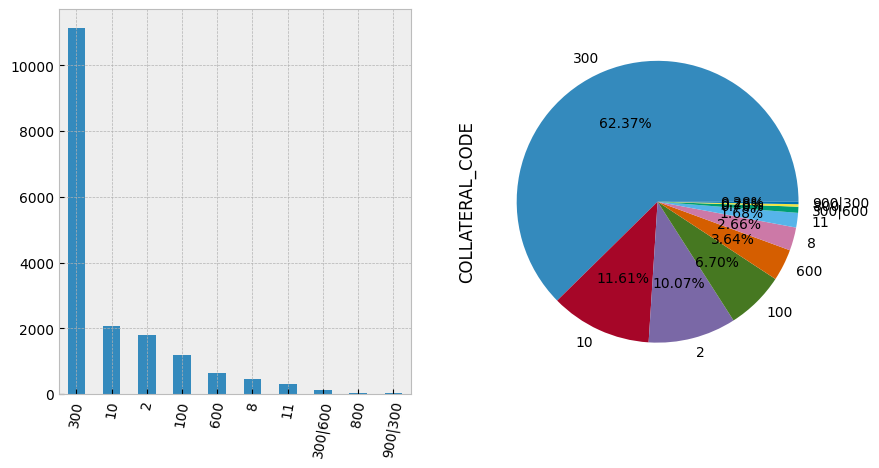

6892820.1                166
1954939.1                150
5094826.1                150
2466936.1                125
223933.1                 100
                        ... 
3304290.1^14355684.1       3
10401455.1^10401455.2      2
2173374.1                  2
600182.1^6559054.1         2
5282947.1^5282947.2        1
Name: COLLATERAL_RIGHT, Length: 683, dtype: int64

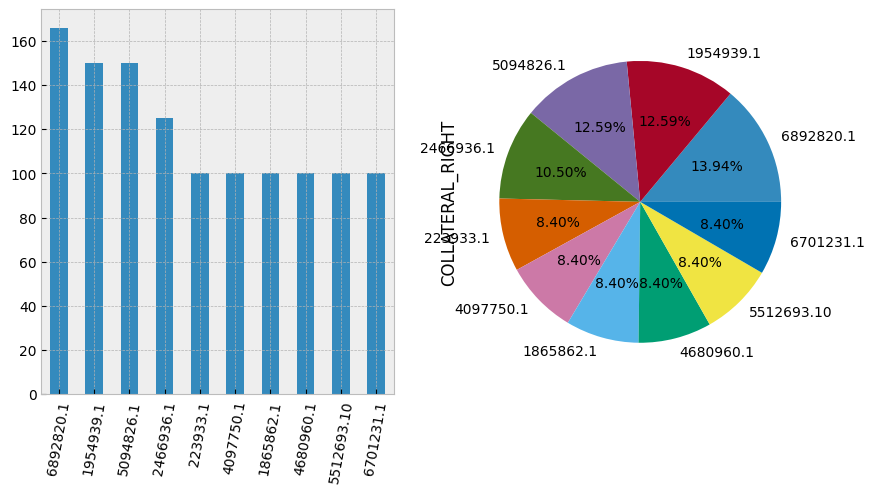

CREATED BY SYSTEM DEFAULT                             51476
MO MOI HAN MUC CHO KHACH HANG                         32377
MO MOI HAN MUC CHO KHACH HANG.                          204
CHUYEN DOI DU LIEU PNB                                  100
MO MOI HAN MUC CHO KHACH HANG|DANG THUY NGUYET QUE       75
MO HAN MUC KH- TRANG HUYNH THI|KIEU OANH                 50
MO HAN MUC KH-TRANG H T KIEU OANH                        50
NANG HAN MUC CHO KHACH HANG                              50
GIA HAN HAN MUC CHO KHACH HANG                           25
GIA HAN MUC CHO KHACH HANG                               25
MO MOI HAN MUC-LE THI KIM TRANG                          25
MO MOI HAN MUC CHO KH                                    25
MO HAN MUC                                               25
MO MOI HM KH TRAN TIEN DUNG                              25
Name: NOTE, dtype: int64

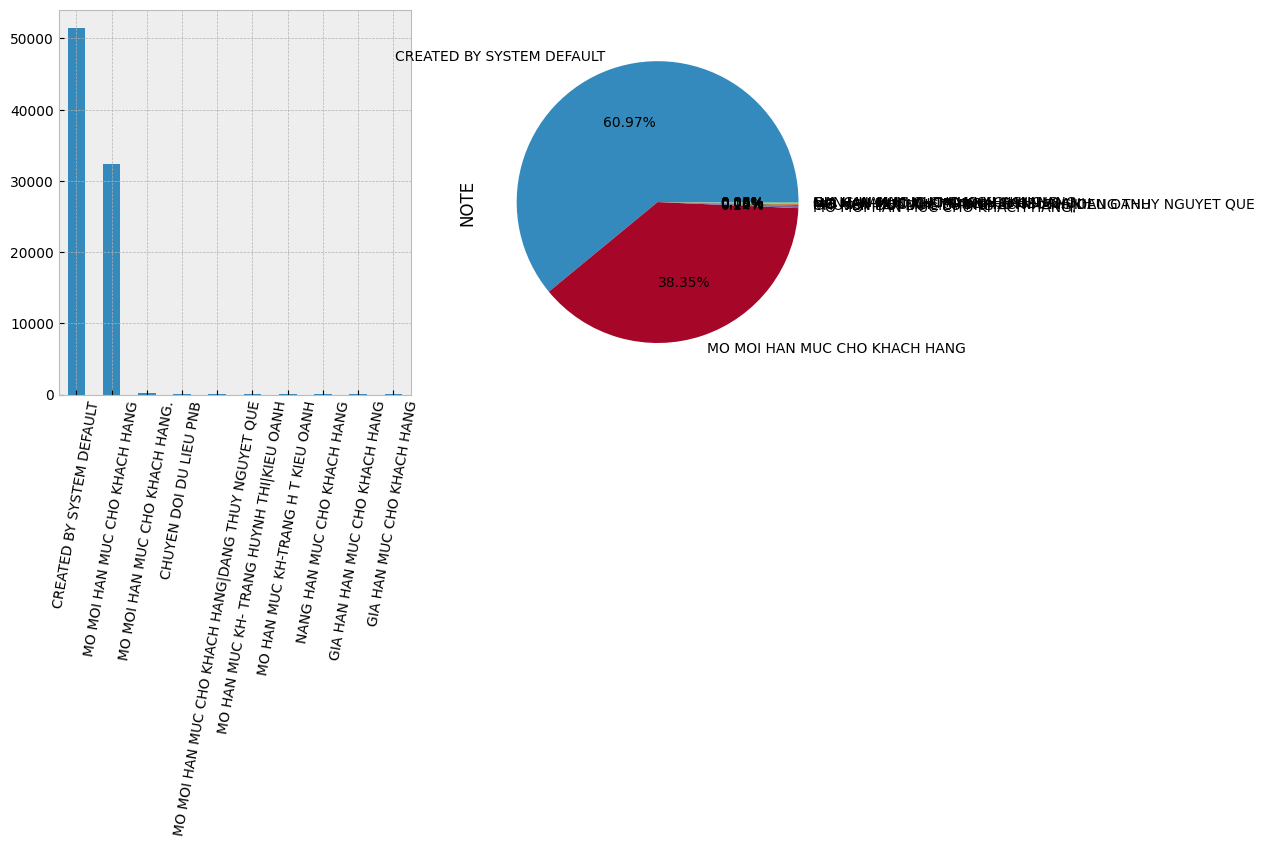

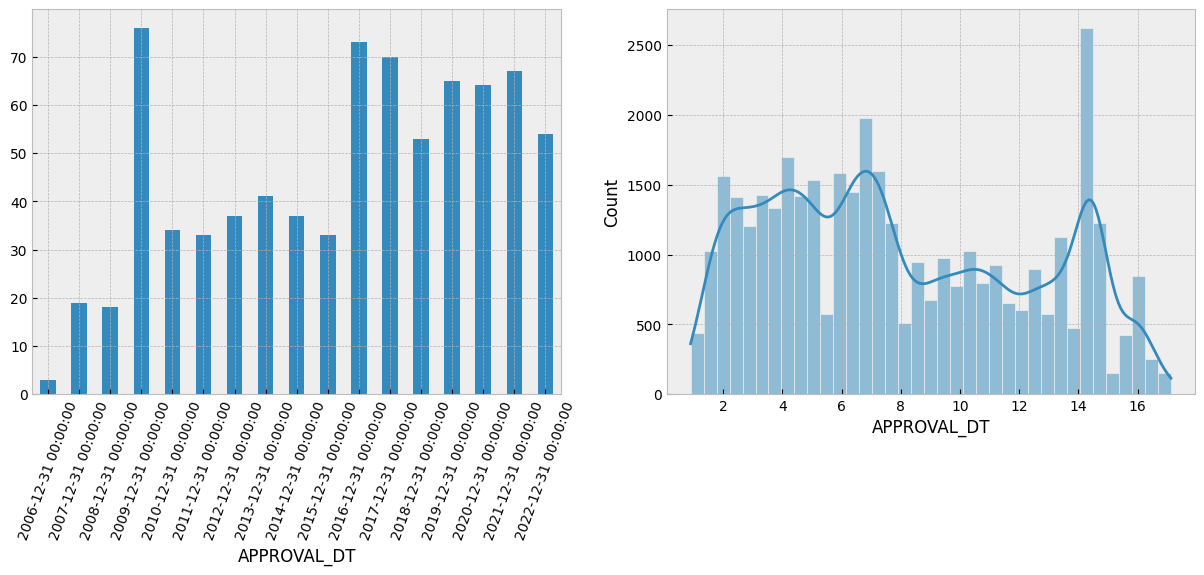

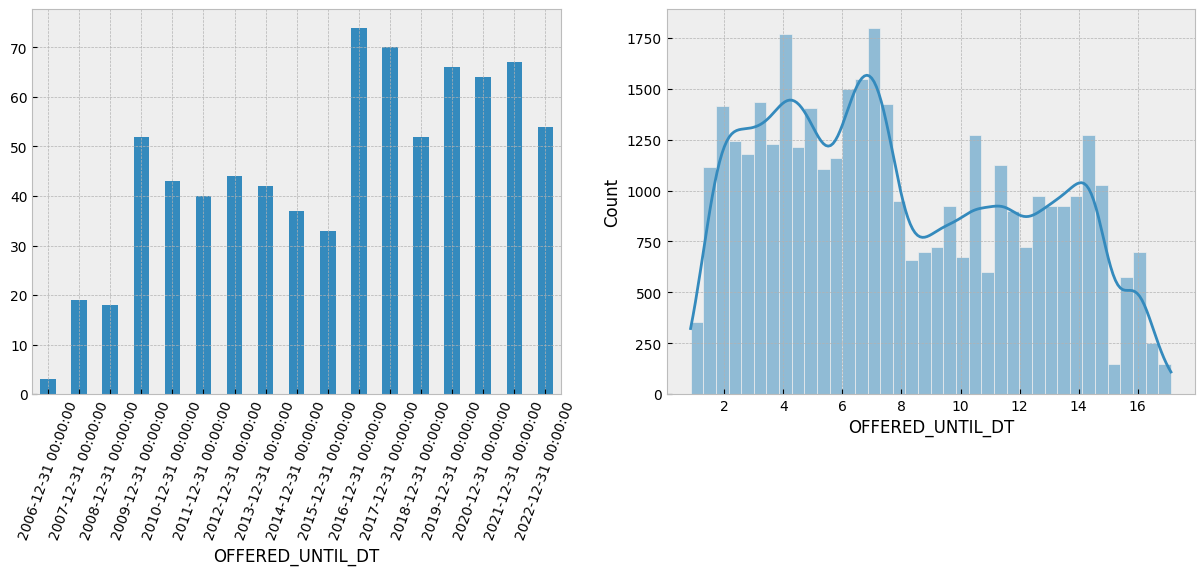

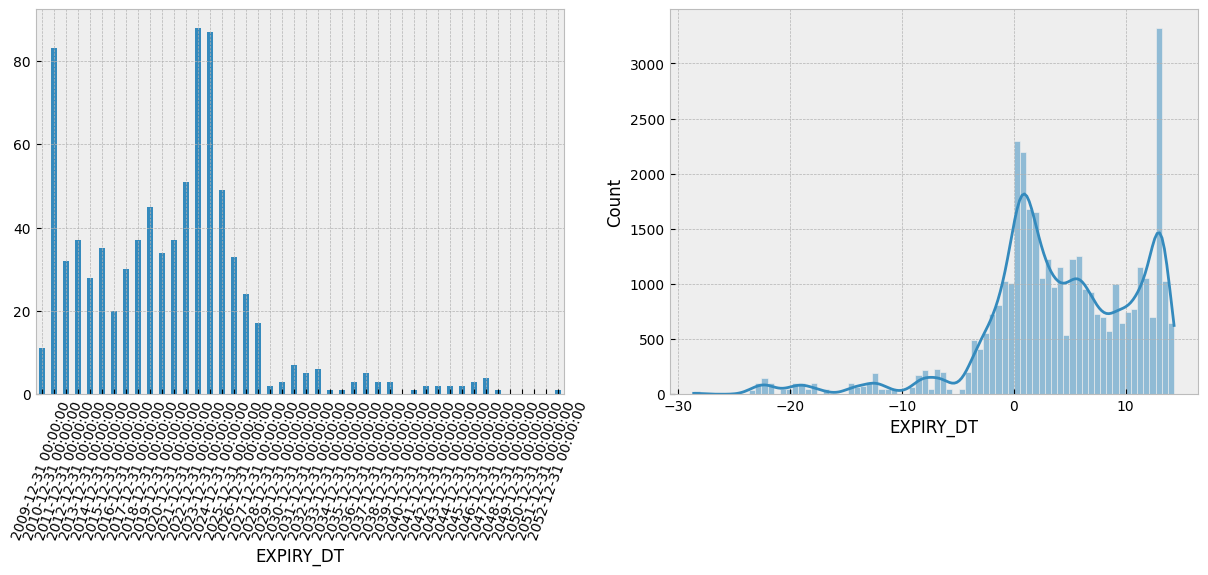

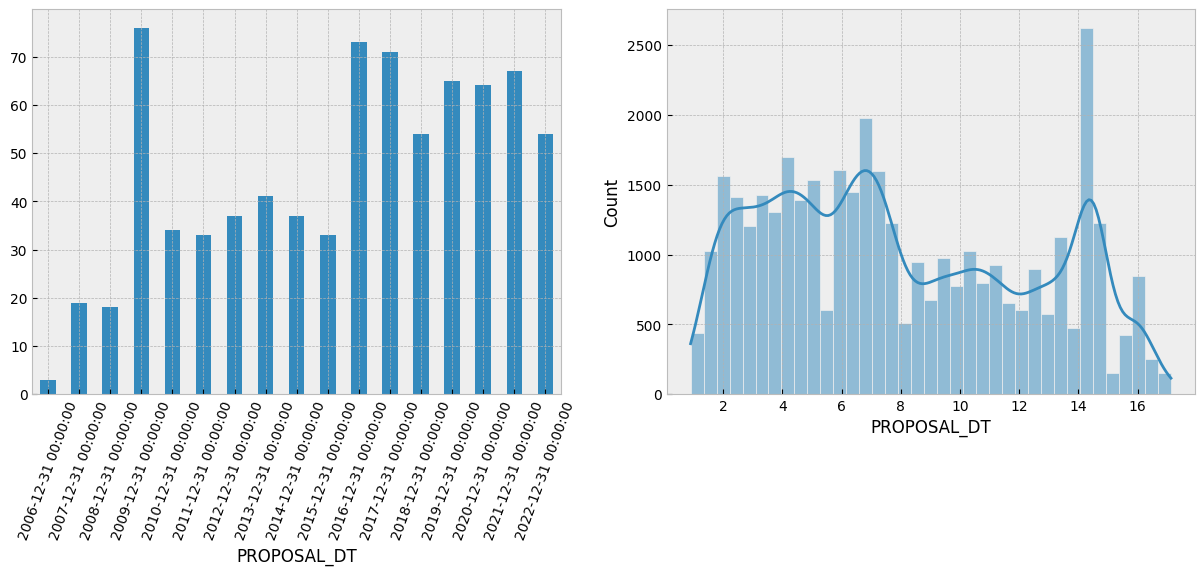

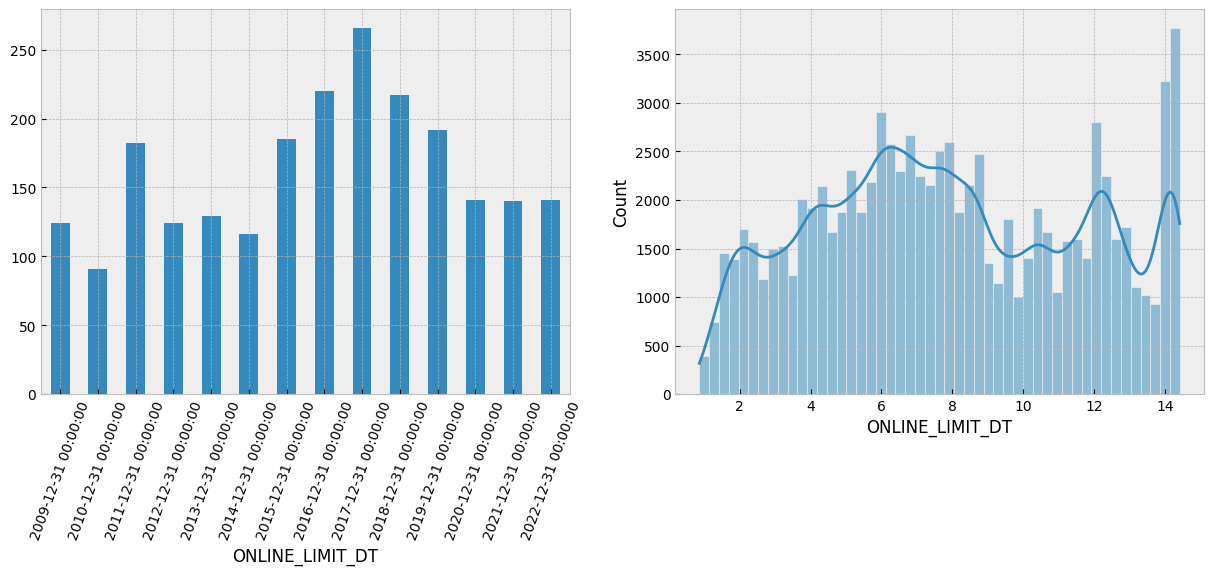

,default_func,remove_mode_value,logx
count,89482.000,75.000,75.000
count_pct_chg,100.000,-99.916,-99.916
mean,20.771,23589.400,10.068
mean_pct_chg,100.000,113470.056,-51.528
median,1.000,23365.000,10.059
median_pct_chg,100.000,2336400.000,905.899
min,1.000,22649.000,10.028
min_pct_chg,100.000,2264800.000,902.787
max,24817.000,24817.000,10.119
max_pct_chg,100.000,0.000,-99.959


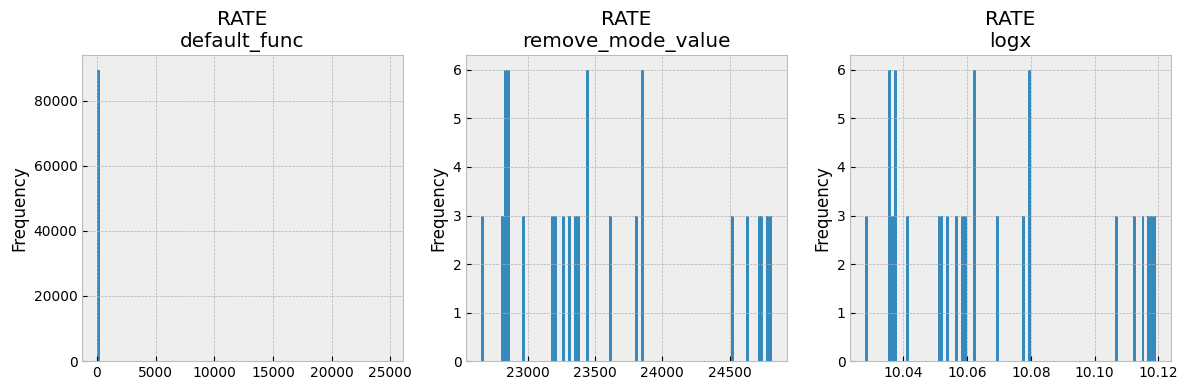

,default_func,remove_mode_value,logx
count,89482.000,33967.000,33967.000
count_pct_chg,100.000,-62.040,-62.040
mean,354808032.355,934699336.155,19.645
mean_pct_chg,100.000,163.438,-100.000
median,0.000,300666667.000,19.522
median_pct_chg,100.000,inf,inf
min,0.000,500000.000,13.122
min_pct_chg,100.000,inf,inf
max,30000000000.000,30000000000.000,24.124
max_pct_chg,100.000,0.000,-100.000


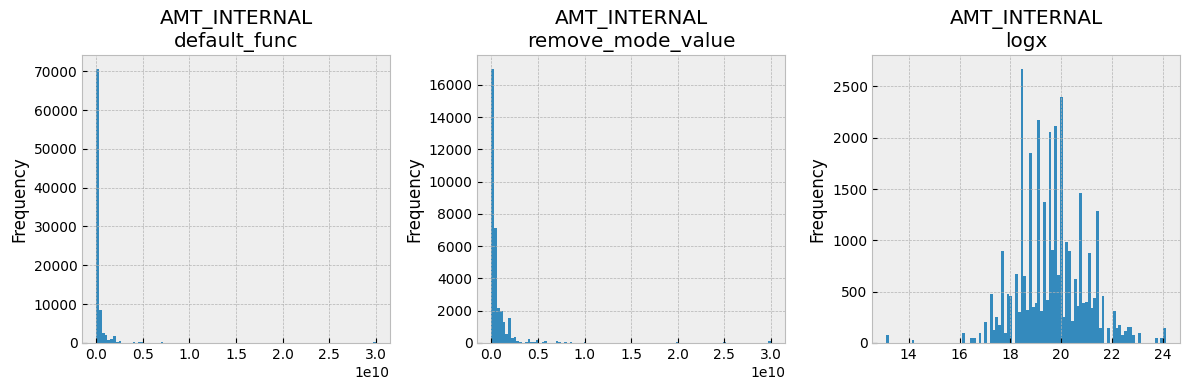

,default_func,remove_mode_value,logx
count,89482.000,30926.000,30926.000
count_pct_chg,100.000,-65.439,-65.439
mean,287149169.006,830844012.837,19.655
mean_pct_chg,100.000,189.342,-100.000
median,0.000,333000000.000,19.624
median_pct_chg,100.000,inf,inf
min,0.000,500000.000,13.122
min_pct_chg,100.000,inf,inf
max,25000000000.000,25000000000.000,23.942
max_pct_chg,100.000,0.000,-100.000


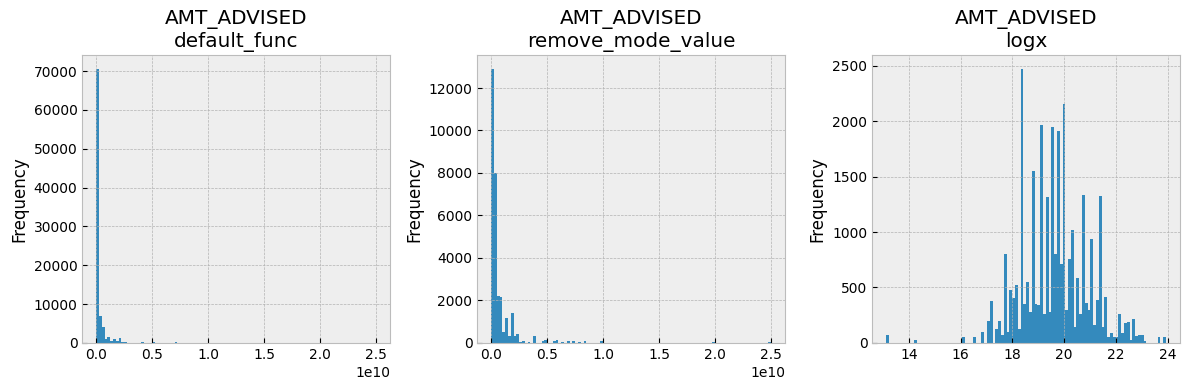

,default_func,remove_mode_value,logx
count,89482.000,10286.000,10286.000
count_pct_chg,100.000,-88.505,-88.505
mean,126221434.316,1098050397.183,19.586
mean_pct_chg,100.000,769.940,-100.000
median,0.000,348329500.000,19.669
median_pct_chg,100.000,inf,inf
min,0.000,222222.000,12.311
min_pct_chg,100.000,inf,inf
max,25000000000.000,25000000000.000,23.942
max_pct_chg,100.000,0.000,-100.000


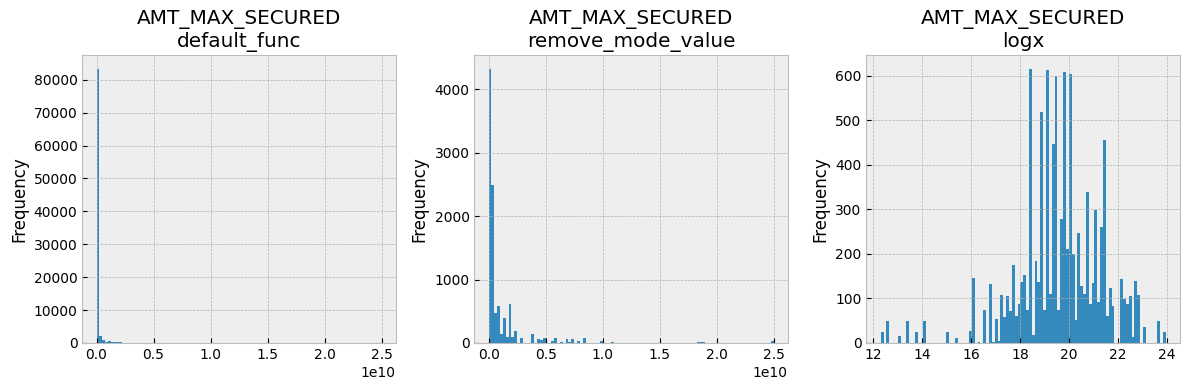

,default_func,remove_mode_value,logx
count,89482.000,528.000,528.000
count_pct_chg,100.000,-99.410,-99.410
mean,2312863.459,391969030.303,18.217
mean_pct_chg,100.000,16847.348,-99.999
median,0.000,150000000.000,18.826
median_pct_chg,100.000,inf,inf
min,0.000,290000.000,12.578
min_pct_chg,100.000,inf,inf
max,2000000000.000,2000000000.000,21.416
max_pct_chg,100.000,0.000,-100.000


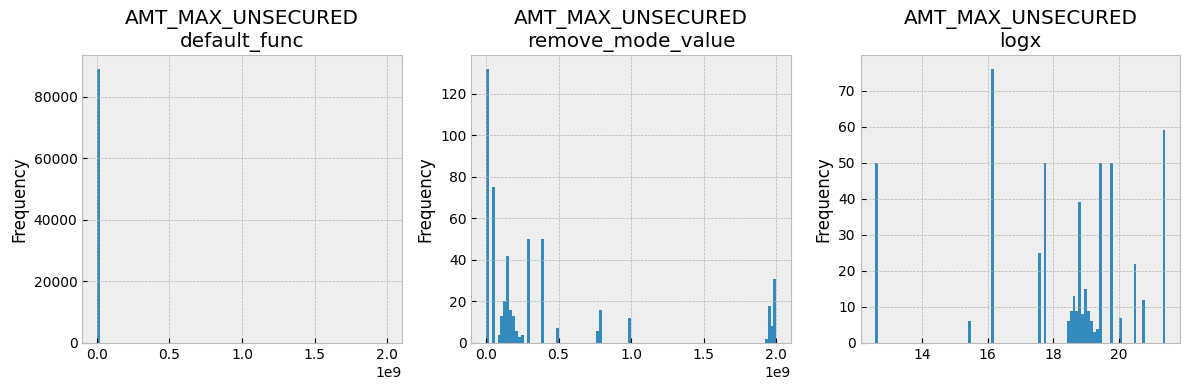

,default_func,remove_mode_value,logx
count,47406.000,18913.000,18913.000
count_pct_chg,100.000,-60.104,-60.104
mean,487324422.787,1221493236.750,19.549
mean_pct_chg,100.000,150.653,-100.000
median,0.000,350000000.000,19.673
median_pct_chg,100.000,inf,inf
min,0.000,222222.000,12.311
min_pct_chg,100.000,inf,inf
max,30000000000.000,30000000000.000,24.124
max_pct_chg,100.000,0.000,-100.000


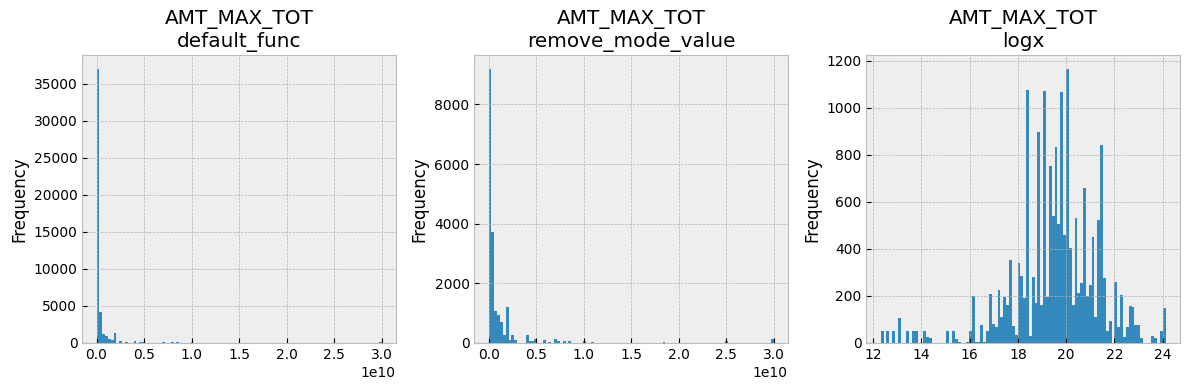

,default_func,remove_mode_value,logx
count,36491.000,15339.000,15339.000
count_pct_chg,100.000,-57.965,-57.965
mean,415954830.601,989543498.499,19.532
mean_pct_chg,100.000,137.897,-100.000
median,0.000,300000000.000,19.519
median_pct_chg,100.000,inf,inf
min,0.000,500000.000,13.122
min_pct_chg,100.000,inf,inf
max,30000000000.000,30000000000.000,24.124
max_pct_chg,100.000,0.000,-100.000


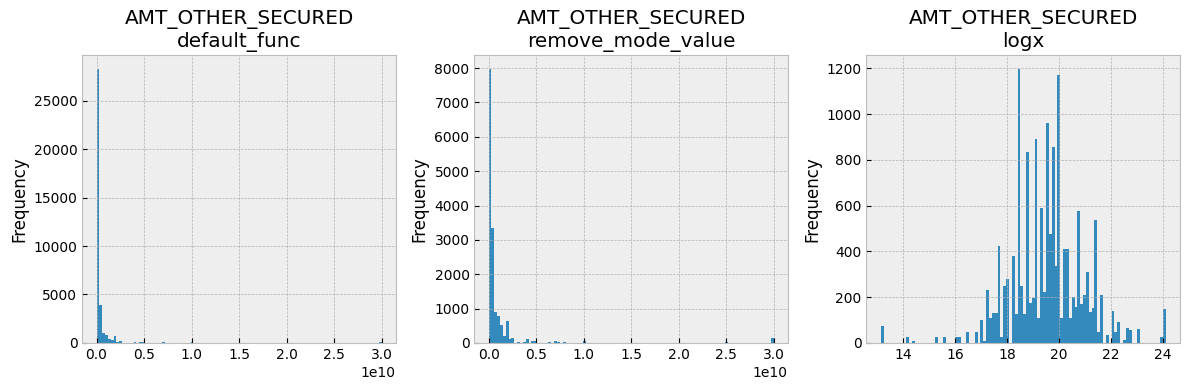

,default_func,remove_mode_value,logx
count,89482.000,3491.000,3491.000
count_pct_chg,100.000,-96.099,-96.099
mean,45053453.329,1154818994.792,19.952
mean_pct_chg,100.000,2463.220,-100.000
median,0.000,479375000.000,19.988
median_pct_chg,100.000,inf,inf
min,0.000,360100.000,12.794
min_pct_chg,100.000,inf,inf
max,19133329000.000,19133329000.000,23.675
max_pct_chg,100.000,0.000,-100.000


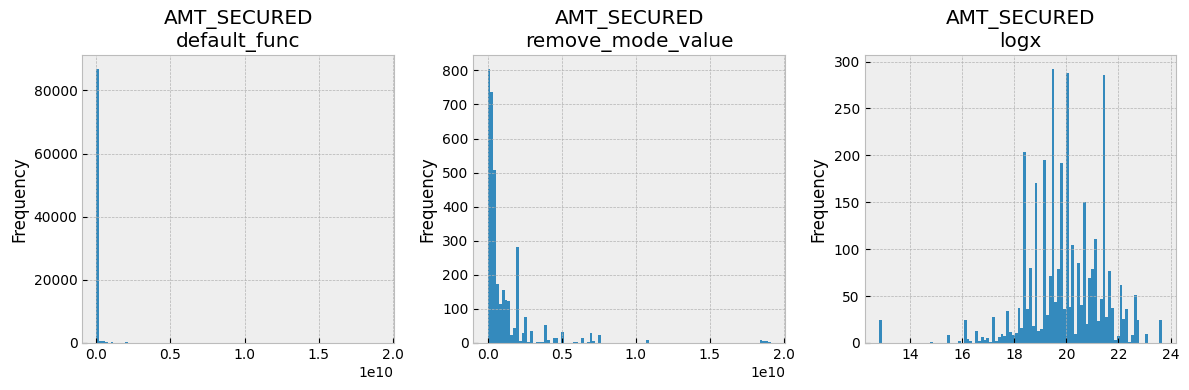

,default_func,remove_mode_value,logx
count,89482.000,14124.000,14124.000
count_pct_chg,100.000,-84.216,-84.216
mean,217767627.674,1379657523.328,19.652
mean_pct_chg,100.000,533.546,-100.000
median,0.000,400000000.000,19.807
median_pct_chg,100.000,inf,inf
min,0.000,222222.000,12.311
min_pct_chg,100.000,inf,inf
max,30000000000.000,30000000000.000,24.124
max_pct_chg,100.000,0.000,-100.000


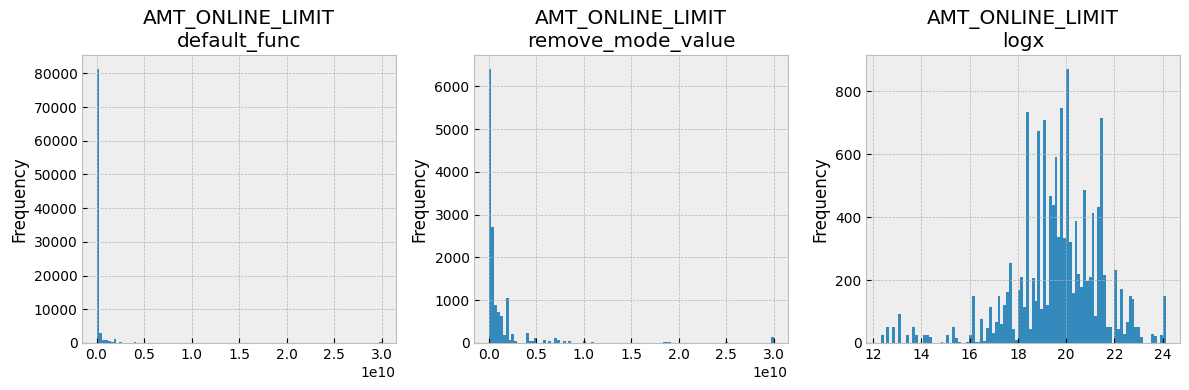

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,89482.000,18380.000,4844.000
count_pct_chg,100.000,-79.460,-94.587
mean,-91344282.261,-444704519.332,8.731
mean_pct_chg,100.000,386.844,-100.000
median,0.000,-390000.000,8.674
median_pct_chg,100.000,-inf,inf
min,-19133329000.000,-19133329000.000,1.099
min_pct_chg,100.000,-0.000,-100.000
max,52374300.000,52374300.000,17.774
max_pct_chg,100.000,0.000,-100.000


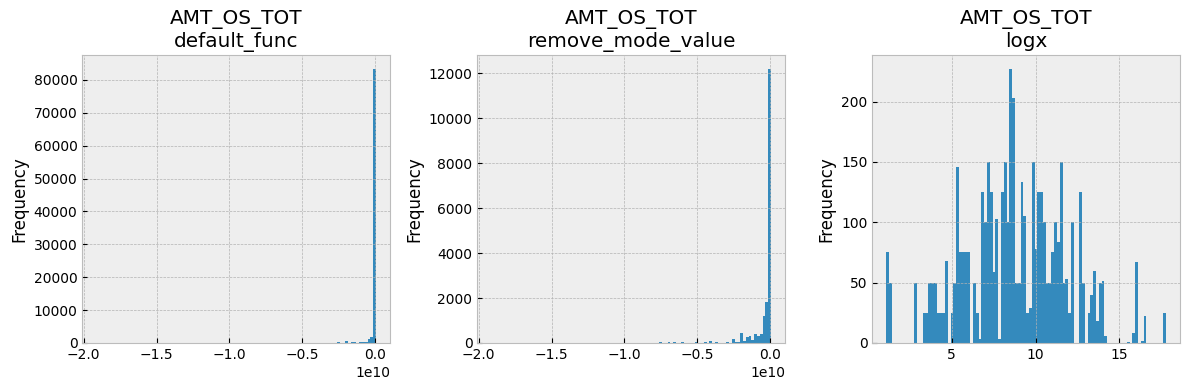

/opt/bitnami/miniconda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,default_func,remove_mode_value,logx
count,89482.000,9317.000,8698.000
count_pct_chg,100.000,-89.588,-90.280
mean,129819254.327,1246805464.813,19.111
mean_pct_chg,100.000,860.416,-100.000
median,0.000,210000000.000,19.337
median_pct_chg,100.000,inf,inf
min,-7150000000.000,-7150000000.000,9.210
min_pct_chg,100.000,-0.000,-100.000
max,30000000000.000,30000000000.000,24.124
max_pct_chg,100.000,0.000,-100.000


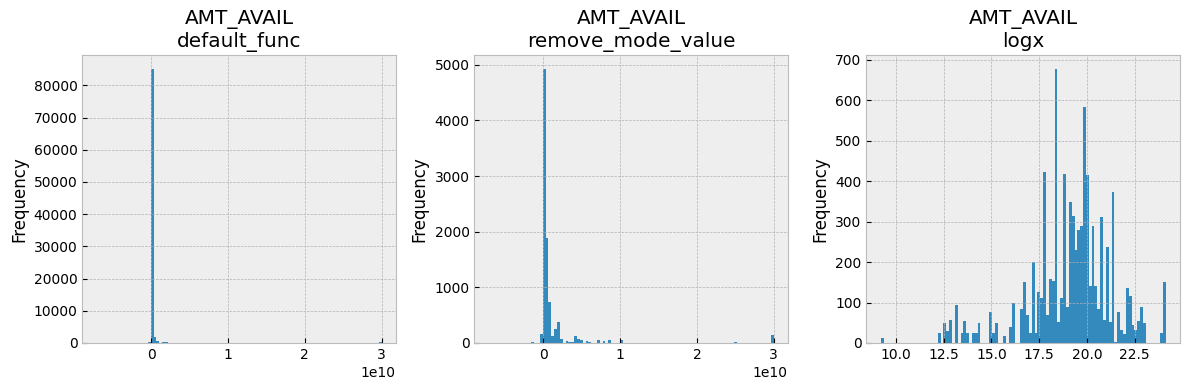

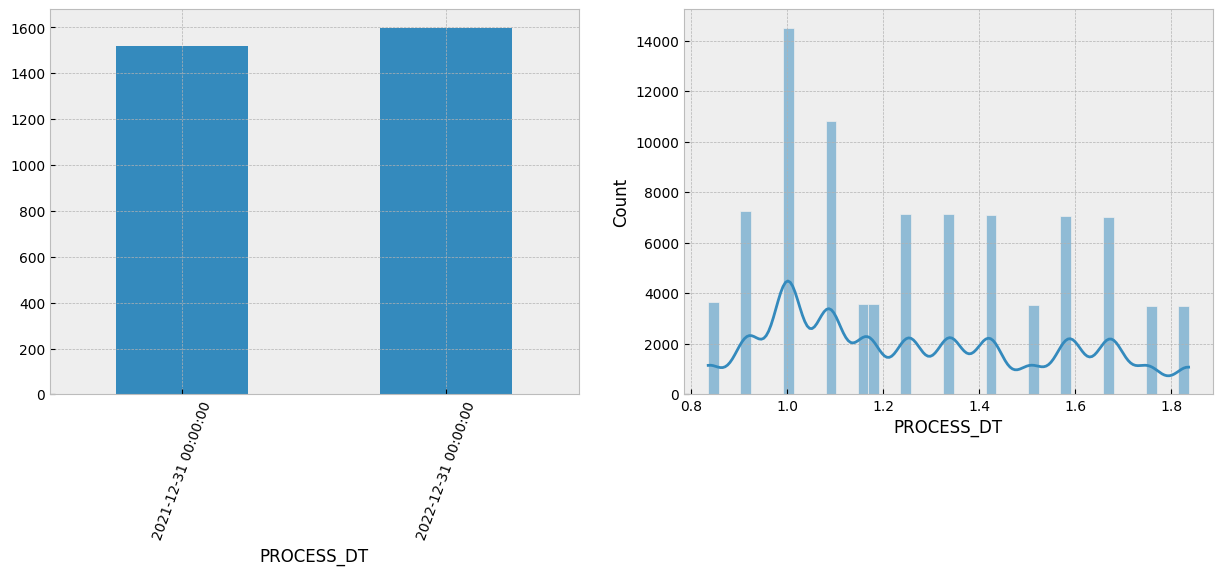

KTH    78315
TH     11167
Name: LIMIT_TYPE, dtype: int64

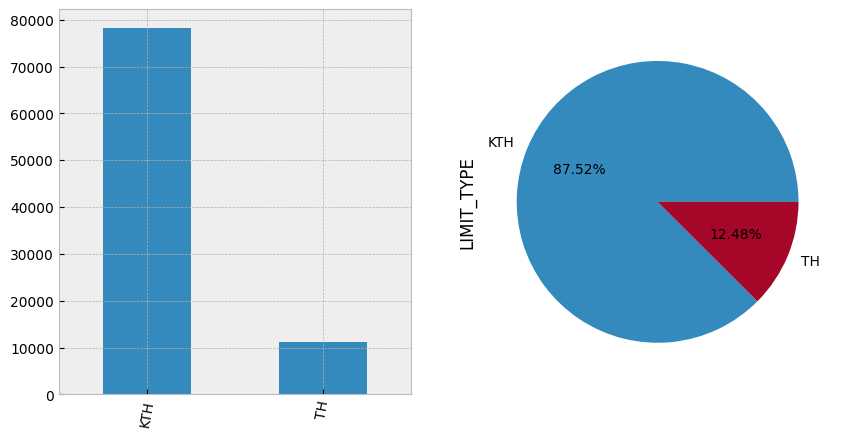

0             33282
500000000       735
100000000       636
200000000       604
2000000000      544
              ...  
7850000000        1
1435000000        1
3750000000        1
4550000000        1
2046908700        1
Name: ONLINE_LIMIT, Length: 708, dtype: int64

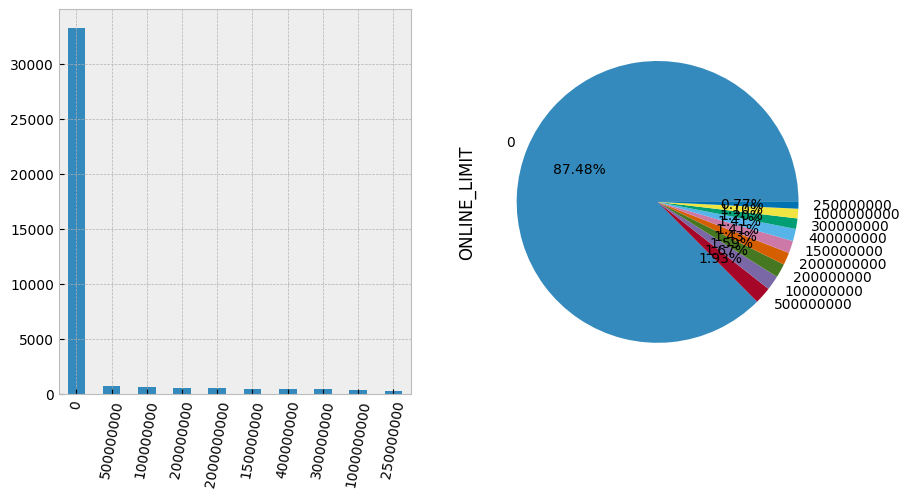

5000     25174
20000    13600
9700     11558
1500      9993
2000      7034
1000      6475
1010      6475
10000     5471
9900      2450
3000       302
3001       277
4600       125
6000        99
6001        99
4601        50
4603        50
7000        50
4608        25
1100        25
1101        25
7001        25
1020        25
4000        25
4001        25
7003        25
Name: LIMIT_PRODUCT_CDE, dtype: int64

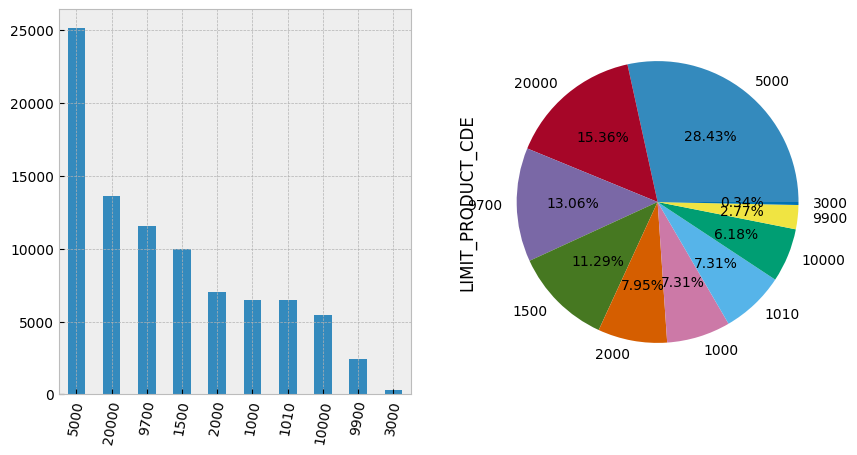

0020000    13600
0025000    13390
0005000    11784
0009700    11558
0001500     9993
0001000     6475
0001010     6475
0010000     5471
0012000     5121
0009900     2450
0002000     1913
0003001      152
0003000      152
0013000      150
0013001      125
0014600      125
0026000       74
0026001       74
0014603       50
0014601       50
0007000       50
0006000       25
0006001       25
0014608       25
0001100       25
0001101       25
0007001       25
0001020       25
0014000       25
0014001       25
0007003       25
Name: LIMIT_TYPE_INIT, dtype: int64

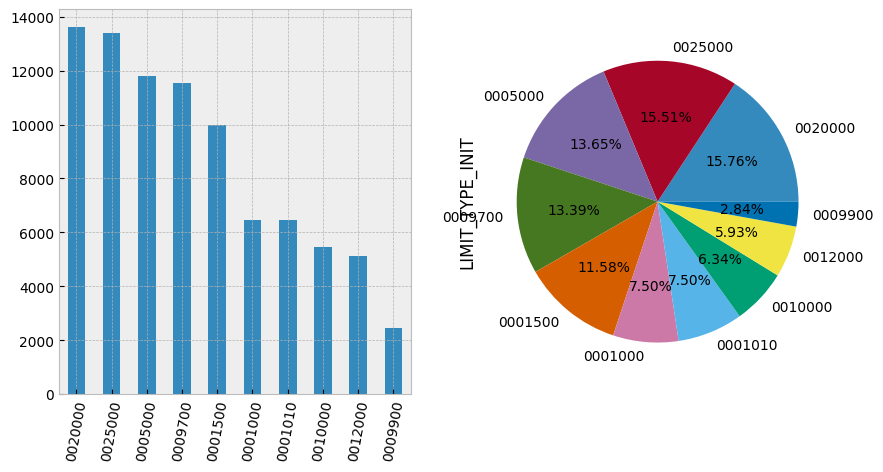

In [24]:
for i, r in valid_info.iterrows():
    if r['Dtype'] == object:
        aly_cat_col(df, [r['Column']])
    elif r['Dtype'] == 'datetime64[ns]':
        aly_datetime(df, r['Column'], 'CUSTOMER_CDE')
    else:
        plot_multi_hist_aly(df, [r['Column']])
    print('\n\n\n')

In [25]:
df.columns, len(df.columns)

(Index(['LIMIT_ID', 'COMPANY_KEY', 'COMPANY_CDE', 'DAY_KEY', 'CUSTOMER_KEY',
        'CUSTOMER_CDE', 'SUB_INDUSTRY_CDE', 'SUB_SECTOR_CDE', 'SUB_SEGMENT_CDE',
        'CUS_TARGET_CDE', 'CURRENCY_CDE', 'REVIEW_FREQUENCY', 'PRODUCT_ALLOWED',
        'FIXED_VARIABLE', 'COLLATERAL_CODE', 'COLLATERAL_RIGHT', 'NOTE',
        'APPROVAL_DT', 'OFFERED_UNTIL_DT', 'EXPIRY_DT', 'PROPOSAL_DT',
        'ONLINE_LIMIT_DT', 'PERIOD_DT', 'RATE', 'AMT_INTERNAL', 'AMT_ADVISED',
        'AMT_COLL_REQ', 'COLL_REQ_PRCNT', 'AMT_PERIOD', 'PERIOD_PRCNT',
        'AMT_MAX_SECURED', 'AMT_MAX_UNSECURED', 'AMT_MAX_TOT',
        'AMT_OTHER_SECURED', 'AMT_SECURED', 'AMT_ONLINE_LIMIT', 'AMT_OS_TOT',
        'AMT_AVAIL', 'PROCESS_DT', 'REC_CREATE_DT', 'REC_UPDATE_DT',
        'LIMIT_TYPE', 'TIME_CODE', 'LIMIT_BAND', 'ONLINE_LIMIT',
        'LIMIT_PRODUCT_CDE', 'LIMIT_TYPE_INIT', 'AMT_CLEAN_RISK',
        'AMT_CLEAN_RISK_USED', 'AMT_FX_USED_LCL', 'AMT_SOLD_LCL', 'AMT_FX_LCL',
        'LOCAL_REF'],
       dtype='object'),

In [26]:
valid_info.set_index('Column').index, len(valid_info['Column'].index)

(Index(['LIMIT_ID', 'SUB_INDUSTRY_CDE', 'SUB_SECTOR_CDE', 'SUB_SEGMENT_CDE',
        'CUS_TARGET_CDE', 'CURRENCY_CDE', 'REVIEW_FREQUENCY', 'PRODUCT_ALLOWED',
        'FIXED_VARIABLE', 'COLLATERAL_CODE', 'COLLATERAL_RIGHT', 'NOTE',
        'APPROVAL_DT', 'OFFERED_UNTIL_DT', 'EXPIRY_DT', 'PROPOSAL_DT',
        'ONLINE_LIMIT_DT', 'RATE', 'AMT_INTERNAL', 'AMT_ADVISED',
        'AMT_MAX_SECURED', 'AMT_MAX_UNSECURED', 'AMT_MAX_TOT',
        'AMT_OTHER_SECURED', 'AMT_SECURED', 'AMT_ONLINE_LIMIT', 'AMT_OS_TOT',
        'AMT_AVAIL', 'PROCESS_DT', 'LIMIT_TYPE', 'ONLINE_LIMIT',
        'LIMIT_PRODUCT_CDE', 'LIMIT_TYPE_INIT'],
       dtype='object', name='Column'),
 33)

In [27]:
df.columns

Index(['LIMIT_ID', 'COMPANY_KEY', 'COMPANY_CDE', 'DAY_KEY', 'CUSTOMER_KEY',
       'CUSTOMER_CDE', 'SUB_INDUSTRY_CDE', 'SUB_SECTOR_CDE', 'SUB_SEGMENT_CDE',
       'CUS_TARGET_CDE', 'CURRENCY_CDE', 'REVIEW_FREQUENCY', 'PRODUCT_ALLOWED',
       'FIXED_VARIABLE', 'COLLATERAL_CODE', 'COLLATERAL_RIGHT', 'NOTE',
       'APPROVAL_DT', 'OFFERED_UNTIL_DT', 'EXPIRY_DT', 'PROPOSAL_DT',
       'ONLINE_LIMIT_DT', 'PERIOD_DT', 'RATE', 'AMT_INTERNAL', 'AMT_ADVISED',
       'AMT_COLL_REQ', 'COLL_REQ_PRCNT', 'AMT_PERIOD', 'PERIOD_PRCNT',
       'AMT_MAX_SECURED', 'AMT_MAX_UNSECURED', 'AMT_MAX_TOT',
       'AMT_OTHER_SECURED', 'AMT_SECURED', 'AMT_ONLINE_LIMIT', 'AMT_OS_TOT',
       'AMT_AVAIL', 'PROCESS_DT', 'REC_CREATE_DT', 'REC_UPDATE_DT',
       'LIMIT_TYPE', 'TIME_CODE', 'LIMIT_BAND', 'ONLINE_LIMIT',
       'LIMIT_PRODUCT_CDE', 'LIMIT_TYPE_INIT', 'AMT_CLEAN_RISK',
       'AMT_CLEAN_RISK_USED', 'AMT_FX_USED_LCL', 'AMT_SOLD_LCL', 'AMT_FX_LCL',
       'LOCAL_REF'],
      dtype='object')

## COMPARE SAMPLES - SUB1/2/3